# Introduction

This tutorial aims to build step-by-step a Support Vector Machine (SVM) and a K-nearest neighbour (KNN) classifiers.
One of the motivation behind its development is the gap in the tutorial space between the very high level implementations (for example on widespread machine-learning packages such as Scikit-learn and Tensorflow)and the very low one, for example for people that develop such methods (in this case advanced knowledge of computer science and mathematics are required). 
What is commonly missing is an introduction to the principles of the machine-learning algorithms for people who want to deep into the method without necessarily possessing a degree in mathematics, and therefore, this project addresses exactly this target of people.
To understand the content, it is necessary to have basic knowledges of linear algebra (mostly dot product and matrix multiplication), its implementation in Numpy and a few commonly used packages (Pandas, Matplotlib).

In order to make this project accessible, in the SVM section, the identification of the support vectors (by gradient descent) is based on the "Perceptron" algorithm. A good description of the theory of this method can be found at this link:  https://page.mi.fu-berlin.de/rojas/neural/chapter/K4.pdf.
The packages available in the repositories identify the support vectors in different ways (for example by solving a Lagrange multiplier equation) which are on the one hand more efficient, but, on the other hand less accessible. 

In [1]:
# imports and plot customizations
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

matplotlib.rcParams['xtick.color'] = 'grey'
matplotlib.rcParams['ytick.color'] = 'grey'
matplotlib.rcParams['xtick.major.size'] = 7
matplotlib.rcParams['ytick.major.size'] = 7
# matplotlib.rcParams['xtick.labelsize'] = 10
# matplotlib.rcParams['ytick.labelsize'] = 10
matplotlib.rcParams['font.size'] = 11
matplotlib.rcParams['xtick.major.pad'] = 8
matplotlib.rcParams['ytick.major.pad'] = 8
matplotlib.rcParams['legend.frameon'] = False
matplotlib.rcParams['axes.edgecolor'] = 'grey'
matplotlib.rcParams['text.color'] = 'grey'
matplotlib.rcParams['xtick.minor.visible'] = True
matplotlib.rcParams['ytick.minor.visible'] = True
matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False
matplotlib.rcParams['legend.loc'] = 'upper left'
matplotlib.rcParams['figure.constrained_layout.h_pad'] = 0.12
matplotlib.rcParams['figure.constrained_layout.w_pad'] = 0.12

The SVM method works by identifying a vector whose dotproduct defines a hyperplane separating 2 categories. If the dataset contains more than 2 categories, a model for each combination needs to be fitted.
In the example below we select a portion of the Iris dataset containing 2 of the 3 species.

In [2]:
# Load the Iris dataset
iris = pd.read_csv(
    'http://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data' 
    #names = ['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm', 'Species']
    )

sns.relplot(data = iris, x = 'SepalLengthCm',  y = 'PetalLengthCm', hue = 'Species')

# Alternatively, the Iris dataset can be loaded from the scikit-learn package (see the Apendix for more information).

In [4]:
# Select 2 categories that do not overlap
iris_model = iris.query('Species == "Iris-setosa" | Species == "Iris-versicolor"')
# Replace the names of the 2 with '-1' and '1' (irrelevant for the Perceptron part but necessary for the SVM)
iris_model = iris_model.replace({'Species':{'Iris-setosa':1, 'Iris-versicolor':-1}})

X = iris_model.loc[:, ['SepalLengthCm',  'PetalLengthCm']].values
y = iris_model.loc[:, 'Species'].values

for d in ('iris', 'X', 'y'):
    print(f'{d}:\n{eval(d + "[0:-1:10]")}')

iris:
      Id  SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm  \
0      1            5.1           3.5            1.4           0.2   
10    11            5.4           3.7            1.5           0.2   
20    21            5.4           3.4            1.7           0.2   
30    31            4.8           3.1            1.6           0.2   
40    41            5.0           3.5            1.3           0.3   
50    51            7.0           3.2            4.7           1.4   
60    61            5.0           2.0            3.5           1.0   
70    71            5.9           3.2            4.8           1.8   
80    81            5.5           2.4            3.8           1.1   
90    91            5.5           2.6            4.4           1.2   
100  101            6.3           3.3            6.0           2.5   
110  111            6.5           3.2            5.1           2.0   
120  121            6.9           3.2            5.7           2.3   
130  131      

# The Perceptron algorithm

In [5]:
def perceptron(X, y, epoch_size = 1e2):
    w_ = np.zeros(X.shape[1]) # start with a random 'w' vector [0,0,...,0]
    epoch_size = int(epoch_size) # epoch is the number of maximum iterations
    errors = np.zeros(epoch_size) # misclassification
    w = np.zeros((epoch_size, X.shape[1]))
    for epoch in range(1, epoch_size + 1):
        for i in range(X.shape[0]):
            y_dot = np.dot(X[i, :], w_)
            # if the dot-product correctly classifies the point we do not change 'w'
            if y_dot <= 0 and y[i] == 1: # if dot-prod negative and the class of the point is positive
                w_ = w_ + X[i, :] 
                errors[epoch-1] += 1
            elif y_dot >= 0 and y[i] == -1: # if dot-prod positive and the class of the point is negative
                w_ = w_ - X[i, :]
                errors[epoch-1] += 1
        w[epoch-1, :] = w_
        # if the wanted result is obtained, there is no need to continue with further iterations and a break can be introduced
        # if errors[epoch-1] == 0:
        #     break
    y_predicted = np.matmul(X, w_)
    errors = errors / X.shape[0]
    w_length = np.apply_along_axis(lambda x: np.sqrt(np.dot(x, x)), axis = 1, arr = w)
    obj = dict(w = w, errors = errors, X = X, y = y, y_predicted = y_predicted, w_length = w_length)
    return obj

In [6]:
def svm_plot(svm_obj, x_var, y_var, suptitle = ''):
    idx_x = np.vstack((np.argmin(svm_obj['X'], axis = 0), np.argmax(svm_obj['X'], axis = 0)))[:, -2] # get the max and min to be plotted
    w = svm_obj['w'][-1]
    colors = ["tab:orange", "grey", "tab:blue"]
    breaks = [0, 0.5, 1] 
    cmap1 = matplotlib.colors.LinearSegmentedColormap.from_list("mycmap1", list(zip(breaks, colors)), N = 50) 
    colors = ['tab:blue', "tab:olive"]
    breaks = [0, 1] 
    cmap2 = matplotlib.colors.LinearSegmentedColormap.from_list("mycmap2", list(zip(breaks, colors)), N = 11)

    fig, ax = plt.subplots(2,2, constrained_layout = True, figsize = (8,8))
    fig.suptitle(suptitle)
    
    # ax[0, 0]
    pl1 = ax[0, 0].scatter(
        svm_obj['X'][:, -2], #  = X[:, 0], negative indexing to account for the object that have the 'b' term 
        svm_obj['X'][:, -1], #  = X[:, 1]
        c = svm_obj['y_predicted'], 
        s = np.power((svm_obj['y'] + 3), 2), # Increase the size of the points (it is based on the original class)
        cmap = cmap1
    )
    for sol, lsty in zip([0, 1, -1], ['-', ':', ':']):
        ax[0, 0].plot(
            svm_obj['X'][idx_x, -2], 
            (-w[1] * svm_obj['X'][idx_x, 1] - w[0] * svm_obj['b'] + sol) / w[2]\
                if ('b' in svm_obj)\
                else (-w[0] * svm_obj['X'][idx_x, 0] + sol) / w[1], 
            c = 'grey', 
            linestyle = lsty
        )
    legend1 = ax[0, 0].legend(
        *pl1.legend_elements(prop = 'colors', num = 3, size = 10), 
        bbox_to_anchor = (1.05, 1), 
        title = 'Predicted y'
    )
    ax[0, 0].add_artist(legend1)
    ax[0, 0].legend(
        handles = pl1.legend_elements(prop = 'sizes', num = 3, color = 'grey')[0][0:3:2], 
        labels = [-1, 1], 
        bbox_to_anchor = (1.05, 0.5), title = 'y'
    )
    ax[0, 0].set(title = 'Prediction', xlabel = x_var, ylabel = y_var)
    
    # ax[0, 1]
    ax[0, 1].plot(svm_obj['errors'], c = 'grey')
    ax[0, 1].set(title = 'Error rate', xlabel = 'Epoch', ylim = [0, 1])
    
    # ax[1, 0]
    pl1 = ax[1, 0].scatter(
        *svm_obj['w'][:, [-2, -1]].T.tolist(), 
        c = list(range(svm_obj['w'].shape[0])), 
        s = 20, 
        cmap = cmap2
    )
    ax[1, 0].legend(
        *pl1.legend_elements(prop = 'colors', num = 10, size = 10), 
        bbox_to_anchor = (1.05, 1),  
        title = 'Epoch'
    )
    ax[1, 0].set( title = 'w', xlabel = x_var, ylabel = y_var)
    
    # ax[1, 1]
    ax[1, 1].plot(svm_obj['w_length'], c = 'grey')
    ax[1, 1].set(title = 'Length of  w', xlabel = 'Epoch')
    
    for ax_ in ax.ravel():
        ax_.xaxis.label.set_color('grey')
        ax_.yaxis.label.set_color('grey')

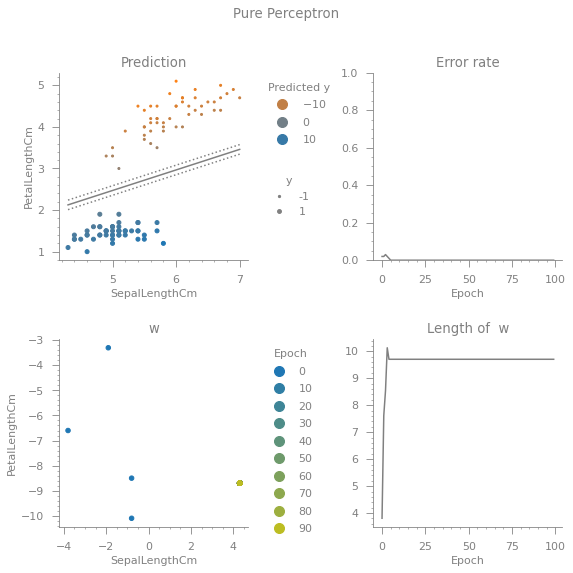

In [7]:
perceptron_obj = perceptron(X, y)     
svm_plot(perceptron_obj, 'SepalLengthCm', 'PetalLengthCm', 'Pure Perceptron')

In [8]:
perceptron_obj

{'w': array([[ -1.9,  -3.3],
        [ -3.8,  -6.6],
        [ -0.8,  -8.5],
        [ -0.8, -10.1],
        [  4.3,  -8.7],
        [  4.3,  -8.7],
        [  4.3,  -8.7],
        [  4.3,  -8.7],
        [  4.3,  -8.7],
        [  4.3,  -8.7],
        [  4.3,  -8.7],
        [  4.3,  -8.7],
        [  4.3,  -8.7],
        [  4.3,  -8.7],
        [  4.3,  -8.7],
        [  4.3,  -8.7],
        [  4.3,  -8.7],
        [  4.3,  -8.7],
        [  4.3,  -8.7],
        [  4.3,  -8.7],
        [  4.3,  -8.7],
        [  4.3,  -8.7],
        [  4.3,  -8.7],
        [  4.3,  -8.7],
        [  4.3,  -8.7],
        [  4.3,  -8.7],
        [  4.3,  -8.7],
        [  4.3,  -8.7],
        [  4.3,  -8.7],
        [  4.3,  -8.7],
        [  4.3,  -8.7],
        [  4.3,  -8.7],
        [  4.3,  -8.7],
        [  4.3,  -8.7],
        [  4.3,  -8.7],
        [  4.3,  -8.7],
        [  4.3,  -8.7],
        [  4.3,  -8.7],
        [  4.3,  -8.7],
        [  4.3,  -8.7],
        [  4.3,  -8.7],
        [  

As can be seen from the plot above, the "Perceptron" algorithm correctly classifies each point after 5 iterations. It is important to mention that this algorithm does not identify the hyperplane that separates the 2 categories in the 'best' way (for example defining the widest street as possible between them) since there is no mathematical constraint in the algorithm tests that provides any additional improvement after all of the points have been correctly classified. 

In this example, it is purely by chance that the hyperplane resembles very closely the one obtained by the more advanced SVM implementation.

# Basic SVM

The first improvement to the step above that we are going to introduce is a simple trick that exploit the fact that we changed the categories labels from names to '-1' and '1'.
With this trick we can now use a single test if we multiply the dot-products by the category (y).

The second change we introduce is that the 'learning' (gradient descent) is done in progressively small steps (that's the meaning of '1/epoch'). Do not mind the -2 constant because that is simply the result of the differential equation that forces the street between the support vectors to be the largest.
                                                                                                               
The third change involves the testing, here we test if the result of the dot-product is >=/<= 1 instead of 0 as before. This is the origin of the constranints inposed to the street separating the support-vectors. If it was a different nmber for the 2 conditions, it would imply that the '0' equation is not at the center of the 2 support vectors.
Also, this implies that the 2 (or more) points (1 or more per category) closest to the '0' equation are the support vectors.

In summary, the major improvement up to this point is that we identified a vector 'w' whose dotproduct defines a hyperplane that separates the 2 categories with the widest 'street' in between.

In [9]:
def svm(X, y, epoch_size = 1e4, alpha = 1e-4):
    w_ = np.zeros(X.shape[1])
    epoch_size = int(epoch_size)
    errors = np.zeros(epoch_size) 
    w = np.zeros((epoch_size, X.shape[1]))
    for epoch in range(1, epoch_size + 1):
        y_dots = y * np.matmul(X, w_)
        for i in range(X.shape[0]):
            if y_dots[i] >= 1:
                w_ = w_ + alpha *  (-2/epoch * w_)  #  w_new = w - 2 *eta * w, --> w*(-2 eta)
            else:
                w_ = w_ + alpha * ((-2/epoch * w_) + (X[i, :] * y[i]))  # w_new = w - 2 *eta * (w + x)
                errors[epoch-1] += 1
            w[epoch-1, :] = w_
    y_predicted = np.matmul(X, w_)
    errors = errors / X.shape[0]
    w_length = np.apply_along_axis(lambda x: np.sqrt(np.dot(x, x)), axis = 1, arr = w)
    obj = dict(w = w, errors = errors, X = X, y = y, y_predicted = y_predicted, w_length = w_length)
    return obj

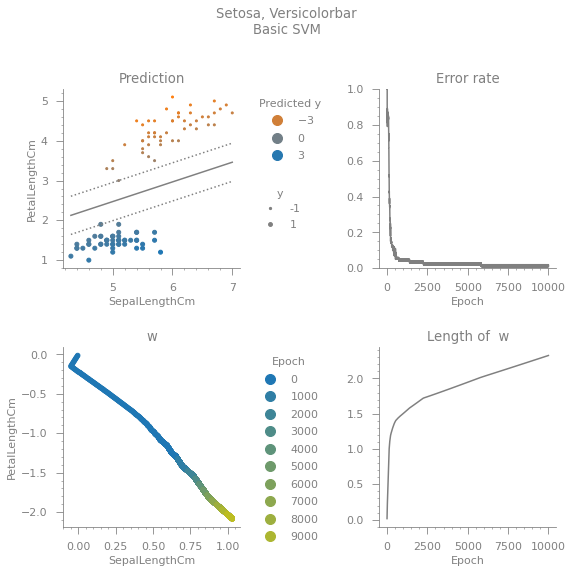

In [10]:
svm_obj = svm(X, y)     
svm_plot(svm_obj, 'SepalLengthCm', 'PetalLengthCm', 'Setosa, Versicolorbar\nBasic SVM')

The effect of the progressively smaller size of the steps (1/epoch) is that most of the improvement is done on the first ~1000 iterations (2nd plot). On the 3rd plot it is possible to see that most of the change in 'w' is achieved during the first ~1000 iterations)

In [11]:
svm_obj

{'w': array([[-0.00487334, -0.01398281],
        [-0.00958711, -0.02782519],
        [-0.01424837, -0.04162135],
        ...,
        [ 1.02956244, -2.08352626],
        [ 1.02953038, -2.08363209],
        [ 1.03000832, -2.08343792]]),
 'errors': array([1.  , 1.  , 1.  , ..., 0.02, 0.02, 0.01]),
 'X': array([[5.1, 1.4],
        [4.9, 1.4],
        [4.7, 1.3],
        [4.6, 1.5],
        [5. , 1.4],
        [5.4, 1.7],
        [4.6, 1.4],
        [5. , 1.5],
        [4.4, 1.4],
        [4.9, 1.5],
        [5.4, 1.5],
        [4.8, 1.6],
        [4.8, 1.4],
        [4.3, 1.1],
        [5.8, 1.2],
        [5.7, 1.5],
        [5.4, 1.3],
        [5.1, 1.4],
        [5.7, 1.7],
        [5.1, 1.5],
        [5.4, 1.7],
        [5.1, 1.5],
        [4.6, 1. ],
        [5.1, 1.7],
        [4.8, 1.9],
        [5. , 1.6],
        [5. , 1.6],
        [5.2, 1.5],
        [5.2, 1.4],
        [4.7, 1.6],
        [4.8, 1.6],
        [5.4, 1.5],
        [5.2, 1.5],
        [5.5, 1.4],
        [4.9, 1.5]

Support vectors are constrained to be +1 and -1, so, they are the closest to 1.

Due to numerical reasons caused by the fact that the prediction is done by matrix multiplication between float numbers, the predicted values are approximated to some digits, and therefore, they cannot be just identified by looking for the predicted values of +1 and -1


Text(0, 0.5, 'PetalLengthCm')

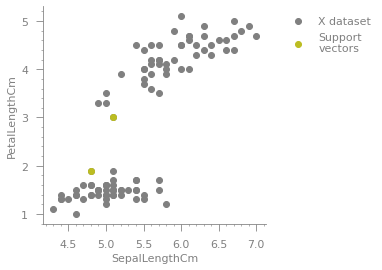

In [12]:
sv = np.argsort(np.abs(svm_obj['y_predicted']) - 1)[0:2]

fig, ax = plt.subplots(1,1, figsize = (4,4))
ax.scatter(X[:, 0], X[:, 1], c = 'grey', label = 'X dataset')
ax.scatter(X[sv, 0], X[sv, 1], c = 'tab:olive', label = 'Support\nvectors')
ax.legend(bbox_to_anchor = (1.05, 1))
ax.set_xlabel('SepalLengthCm', color = 'grey')
ax.set_ylabel('PetalLengthCm', color = 'grey')

# SVM with additional 'b' (bias) constant

In [13]:
def svm_2(X, y, epoch_size = 1e4, alpha = 1e-4, b = 1):
    X = np.column_stack((np.array([b] * X.shape[0]), X)) # add a b constant column in position 0 pf the X matrix
    w_ = np.zeros(X.shape[1])
    epoch_size = int(epoch_size)
    errors = np.zeros(epoch_size) 
    w = np.zeros((epoch_size, X.shape[1]))
    for epoch in range(1, epoch_size + 1):
        y_dots = y * np.matmul(X, w_)
        for i in range(X.shape[0]):
            if y_dots[i] >= 1:
                w_ = w_ + alpha *  (-2/epoch * w_) 
            else:
                w_ = w_ + alpha * ((-2/epoch * w_) + (X[i, :] * y[i]))
                errors[epoch-1] += 1
            w[epoch-1, :] = w_
    y_predicted = np.matmul(X, w_)
    errors = errors / X.shape[0]
    w_length = np.apply_along_axis(lambda x: np.sqrt(np.dot(x, x)), axis = 1, arr = w)
    obj = dict(w = w, errors = errors, X = X, y = y, y_predicted = y_predicted, w_length = w_length, b = b)
    return obj

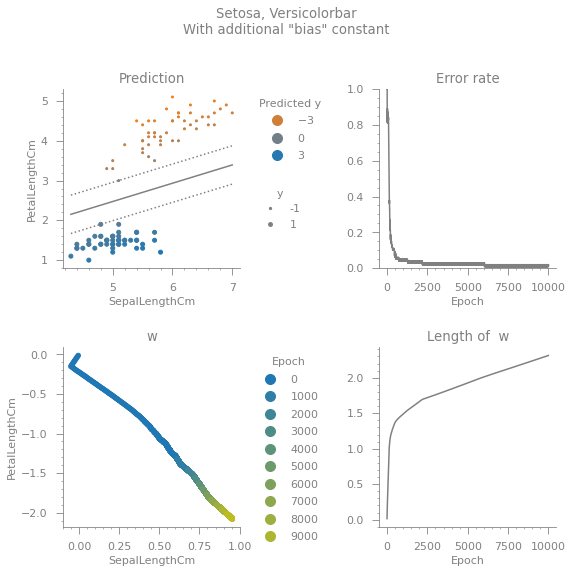

In [14]:
svm_obj_b_coef = svm_2(X, y)     
svm_plot(svm_obj_b_coef, 'SepalLengthCm', 'PetalLengthCm', 'Setosa, Versicolorbar\nWith additional "bias" constant')

The addition of the 'b' constant does not change the actual hyperplane. It just modifies the value and length of the'w' vector

# SVM with soft margin

In [15]:
def svm_3(X, y, epoch_size = 1e4, alpha = 1e-4, b = 1, c = 10): # Add the 'c' term (the soft margim term)
    X = np.column_stack((np.array([b] * X.shape[0]), X)) 
    w_ = np.zeros(X.shape[1])
    epoch_size = int(epoch_size)
    errors = np.zeros(epoch_size) 
    w = np.zeros((epoch_size, X.shape[1]))
    for epoch in range(1, epoch_size + 1):
        y_dots = y * np.matmul(X, w_)
        e = np.minimum(1, c / np.sum(y_dots < 1)) 
        for i in range(X.shape[0]):
            if y_dots[i] >= 1 - e: # define the new threshold (define the soft margin)
                w_ = w_ + alpha *  (-2/epoch * w_)  
            else:
                w_ = w_ + alpha * ((-2/epoch * w_) + (X[i, :] * y[i]))  # w_new = w - 2 *eta * (w + x)
                errors[epoch-1] += 1
            w[epoch-1, :] = w_
    y_predicted = np.matmul(X, w_)
    errors = errors / X.shape[0]
    w_length = np.apply_along_axis(lambda x: np.sqrt(np.dot(x, x)), axis = 1, arr = w)
    obj = dict(w = w, errors = errors, X = X, y = y, y_predicted = y_predicted, w_length = w_length, b = b)
    return obj

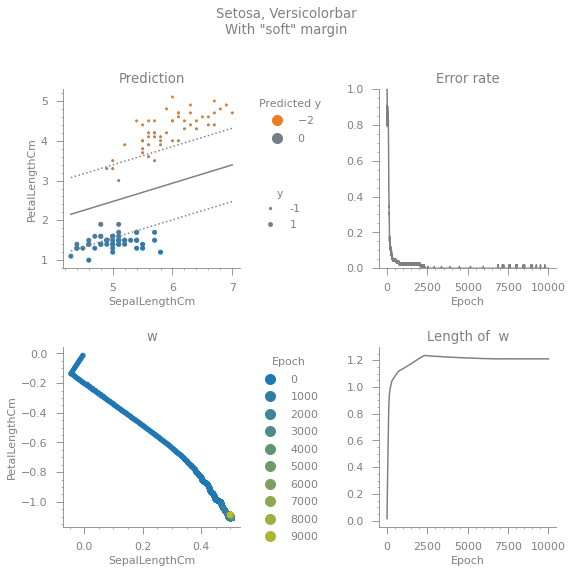

In [16]:
svm_obj_b_coef_c = svm_3(X, y)     
svm_plot(svm_obj_b_coef_c, 'SepalLengthCm', 'PetalLengthCm', 'Setosa, Versicolorbar\nWith "soft" margin')

What we did in this step was simply to modify the threshold of the testing to 0 <= value <= 1. In this way the definition of the hyperplane is relaxed by having a lower threshold. 

There are different ways to implement this step, in this case this was done by simply reducing threshold by c / (sum of misclassifications on iteration) if the sum of misclassification is greater than c.

# Iris-virginica vs Iris-versicolor

The example below runs the same 3 functions as above but on the 2 groups of iris that are not separable by a line. This is a much more realistic example compared to the one above and shows the importance of the soft margins.

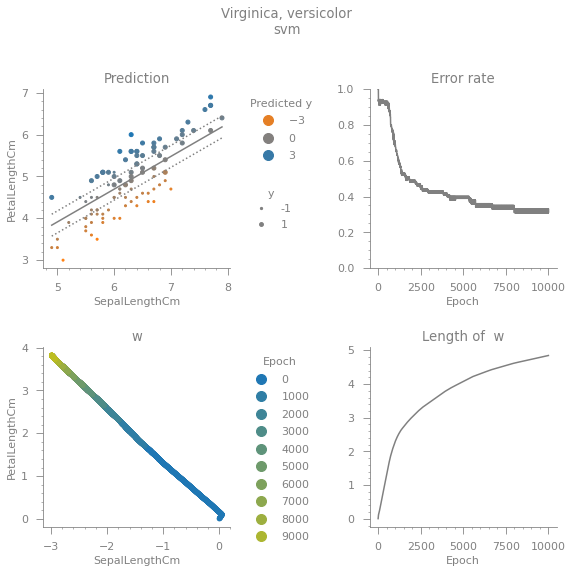

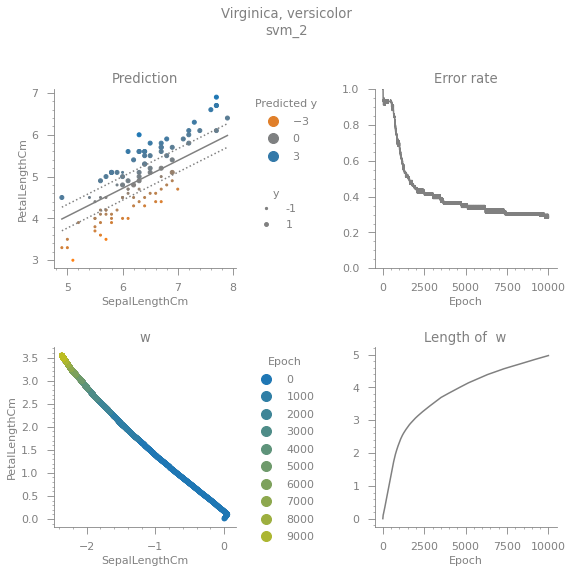

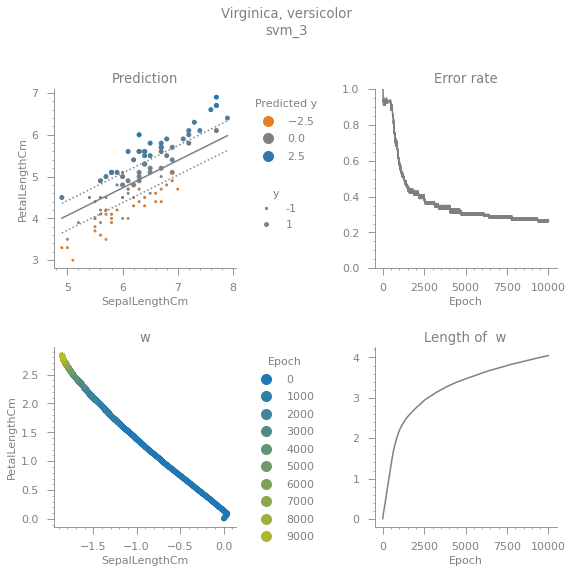

In [17]:
fraction_train = 0.8
iris_model = iris.query('Species == "Iris-virginica" | Species == "Iris-versicolor"')
iris_model = iris_model.replace({'Species':{'Iris-virginica':1, 'Iris-versicolor':-1}})

X2 = iris_model.loc[:, ['SepalLengthCm',  'PetalLengthCm']].values
y2 = iris_model.loc[:, 'Species'].values

functions = [svm, svm_2, svm_3]
svm_virginica_versicolor = list(map(lambda svm: svm(X2, y2), functions))

for x, fun in zip(svm_virginica_versicolor, functions):
    svm_plot(x, 'SepalLengthCm', 'PetalLengthCm', 'Virginica, versicolor\n' + fun.__name__)

# Non-linear SVM

Conversely to the situations in the examples above where the 2 groups can be separated linearly, often this is not possible. One classic example is the one illustrated below where there is no straight line able to separate the 2 groups (one of which located inside the other).

Text(0, 0.5, 'x2')

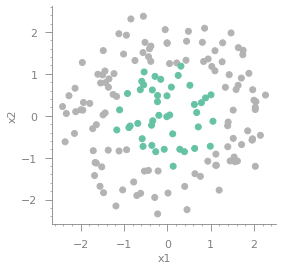

In [18]:
mu_x1_x2 = [0,0]
dataset_test = pd.DataFrame({
     'x1':np.random.normal(mu_x1_x2[0], 2, 300), 
     'x2':np.random.normal(mu_x1_x2[1], 2, 300)
     })

dist_from_mu = np.linalg.norm(dataset_test - np.array(mu_x1_x2)[np.newaxis, :], axis = 1)
dataset_test['category'] = np.select([dist_from_mu < np.std(dist_from_mu)], [ [-1]*dataset_test.shape[0] ], default = 1) # assign the closest to the center to category '-1'
dataset_test = dataset_test.loc[dist_from_mu < 2 * np.std(dist_from_mu), :] # remove outlayer points
del dist_from_mu

_, ax = plt.subplots(1,1, figsize = (4, 4))
ax.scatter(
    x = dataset_test.x1, 
    y = dataset_test.x2, 
    c = dataset_test.category, 
    cmap = 'Set2'
    )
ax.set_xlabel('x1', color = 'grey')
ax.set_ylabel('x2', color = 'grey')

What mentioned above however, does not imply that the 2 groups cannot be separated. In situations such as those there always is a function that can 'deform' the space and make the groups separable; and the good part is that it does not need to have the same number of dimensions. In this example we transform the dataset from R2 to R3: (x1, x2) --> (x1$^2$, x2$^2$, $\sqrt{2}*x1*x2$).

Text(0.5, 0, '$\\sqrt{2}$ x1 x2')

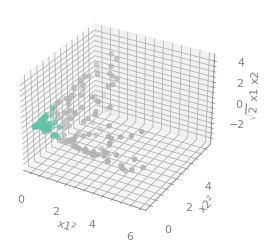

In [19]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize = (4,4))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(
    xs = dataset_test.x1 **2, 
    ys = dataset_test.x2 **2, 
    zs= np.sqrt(2) * dataset_test.x1 * dataset_test.x2,  
    c = np.power((dataset_test.category + 3), 2), 
    cmap = 'Set2'
    )
ax.set_xlabel('x1$^2$', color = 'grey')
ax.set_ylabel(r'x2$^2$', color = 'grey')
ax.set_zlabel(r'$\sqrt{2}$ x1 x2' , color = 'grey')

In this R3 space there exists a hyperplane (with the shape of an actual plane instead of a line like in the previous examples) that separates the 2 categories. 


What is so special from this transformation? In other words, in this particular example, taking just the square of the 2 dimensions would have been enough to define a hyperplane capable of separating the 2 groups.

Text(0, 0.5, 'x2$^2$')

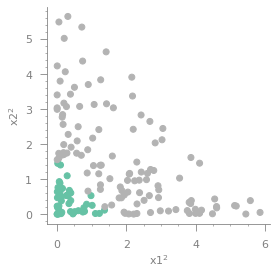

In [20]:
_, ax = plt.subplots(1,1, figsize = (4, 4))
ax.scatter(
    x = dataset_test.x1 ** 2, 
    y = dataset_test.x2 ** 2, 
    c = dataset_test.category, 
    cmap = 'Set2'
    )
ax.set_xlabel('x1$^2$', color = 'grey')
ax.set_ylabel('x2$^2$', color = 'grey')

The answer lies in expanding the dotproduct between the transformed point and the transformed 'w':

let's define the transformation of a vector $\vec x$ as $\phi(\vec x) = (x1^2, x2^2, \sqrt{2}*x1*x2$)

Then: 

$\phi(\vec x) \cdot \phi(\vec w) = (x1^2, x2^2, \sqrt{2} x1 x2) \cdot (w1^2, w2^2, \sqrt{2} w1 w2$) 

$\phi(\vec x) \cdot \phi(\vec w) = x1^2w1^2 + x2^2w2^2 + 2 x1 w1 x2 w2 $

$\phi(\vec x) \cdot \phi(\vec w) = (x1w1 + x2w2)^2 = (\phi(\vec x) \cdot \phi(\vec w))^2$
    
Therefore, the transformation $\phi(\vec x) = (x1^2, x2^2, \sqrt{2}*x1*x2$) when dotted with another vector is simply the suared of the dot-product. In the case of SVM, we donot need to apply the same transformation to 'w' since it is itself the vector we are after.

In [21]:
X_dataset_test = dataset_test.loc[:, ['x1', 'x2']].values
y_dataset_test = dataset_test.loc[:, 'category'].values

def svm_4(X, y, function, epoch_size = 1e4, alpha = 1e-4, b = 1, c = 10):
    X = np.apply_along_axis(eval(function), axis = 1, arr = X) # Kernel trick
    X = np.column_stack((np.array([b] * X.shape[0]), X)) 
    w_ = np.zeros(X.shape[1])
    epoch_size = int(epoch_size)
    errors = np.zeros(epoch_size)
    w = np.zeros((epoch_size, X.shape[1]))
    for epoch in range(1, epoch_size + 1):
        y_dots = y * np.matmul(X, w_)
        errors[epoch-1] = np.sum(y_dots < 1)
        e = np.minimum(1, c / np.sum(y_dots < 1))
        for i in range(X.shape[0]):
            if y_dots[i] >= 1 - e: # define the soft margin
                w_ = w_ + alpha *  (-2/epoch * w_) 
            else:
                w_ = w_ + alpha * ((-2/epoch * w_) + (X[i, :] * y[i]))
                errors[epoch-1] += 1
            w[epoch-1, :] = w_
    y_predicted = np.matmul(X, w_)
    errors = errors / X.shape[0]
    w_length = np.apply_along_axis(lambda x: np.sqrt(np.dot(x, x)), axis = 1, arr = w)
    obj = dict(w = w, errors = errors, X = X, y = y, y_predicted = y_predicted, w_length = w_length, b = b, c = c)
    return obj

In [22]:
non_linear_svm = svm_4(
    X_dataset_test, 
    y_dataset_test, 
    'lambda x: np.array([ x[0]**2, x[1]**2, np.sqrt(2) * x[0] * x[1] ])'
    )

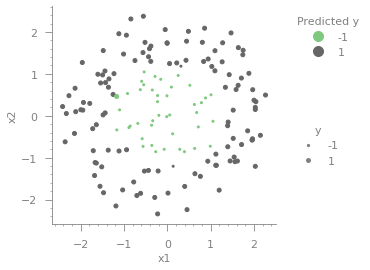

In [23]:
_, ax = plt.subplots(1,1, figsize = (4, 4))

pl1 = ax.scatter(
    x = dataset_test.x1, 
    y = dataset_test.x2, 
    s = np.power((dataset_test.category + 3), 2), 
    c = np.sign(non_linear_svm['y_predicted']),
    cmap = 'Accent'
    )

ax.set_xlabel('x1', color = 'grey')
ax.set_ylabel('x2', color = 'grey')

legend1 = ax.legend(
    pl1.legend_elements(prop='colors', num = 3, size = 10)[0][0:3:2], [-1, 1], 
    bbox_to_anchor = (1.05, 1), title = 'Predicted y'
)
ax.add_artist(legend1)
ax.legend(
    pl1.legend_elements(prop='sizes', num = 3, color = 'grey')[0][0:3:2], 
    [-1, 1], 
    bbox_to_anchor = (1.05, 0.5), title = 'y'
)

# Performance testing of the models

In [24]:
fraction_train = 0.8
iris_model = iris.query('Species == "Iris-virginica" | Species == "Iris-versicolor"')
iris_model = iris_model.replace({'Species':{'Iris-virginica':1, 'Iris-versicolor':-1}})

np.random.seed(6)
idx = np.random.choice(
    iris_model.index.values, 
    replace = False, 
    size = np.int8(np.floor(iris_model.shape[0] * fraction_train))
    )
idx = np.sort(idx)

X_train = iris_model.loc[idx, ['SepalLengthCm',  'PetalLengthCm']].values
y_train = iris_model.loc[idx, 'Species'].values
X_test = iris_model.loc[np.invert(iris_model.index.isin(idx)), ['SepalLengthCm',  'PetalLengthCm']].values 
y_test = iris_model.loc[np.invert(iris_model.index.isin(idx)), 'Species'].values 

In [25]:
functions = [svm, svm_2, svm_3]
svm_train = list(map(lambda svm: svm(X_train, y_train), functions))

In [26]:
for func, x in zip(functions, svm_train):
    print(f'Classification train: {func.__name__}:\n {np.sign(x["y_predicted"])}') 

Classification train: svm:
 [-1. -1. -1.  1. -1. -1. -1. -1. -1. -1. -1. -1.  1. -1. -1. -1.  1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1.  1. -1. -1. -1. -1. -1.  1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1. -1.
  1.  1.  1. -1.  1.  1.  1.  1.]
Classification train: svm_2:
 [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1. -1. -1. -1.  1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.
  1.  1.  1. -1.  1.  1.  1.  1.]
Classification train: svm_3:
 [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1. -1. -1. -1.  1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. 

In [27]:
svm_train

[{'w': array([[ 3.16875393e-04,  3.35896637e-03],
         [ 5.33167382e-04,  6.62694850e-03],
         [ 7.16293841e-04,  9.86492204e-03],
         ...,
         [-3.00941828e+00,  3.82195680e+00],
         [-3.00954346e+00,  3.82201069e+00],
         [-3.00966863e+00,  3.82206458e+00]]),
  'errors': array([1.   , 1.   , 1.   , ..., 0.325, 0.325, 0.325]),
  'X': array([[7. , 4.7],
         [5.5, 4. ],
         [6.5, 4.6],
         [5.7, 4.5],
         [6.3, 4.7],
         [4.9, 3.3],
         [5.2, 3.9],
         [5.9, 4.2],
         [6. , 4. ],
         [6.1, 4.7],
         [5.6, 3.6],
         [6.7, 4.4],
         [5.6, 4.5],
         [5.8, 4.1],
         [6.2, 4.5],
         [5.6, 3.9],
         [5.9, 4.8],
         [6.1, 4. ],
         [6.3, 4.9],
         [6.1, 4.7],
         [6.4, 4.3],
         [6.7, 5. ],
         [6. , 4.5],
         [5.7, 3.5],
         [5.5, 3.8],
         [5.8, 3.9],
         [5.4, 4.5],
         [6. , 4.5],
         [6.7, 4.7],
         [6.3, 4.4],
      

In [28]:
def misclassification(y_classification, y_test):
    agreement = y_classification * y_test # -1 = disagreement; 1 = agreement
    counts = np.histogram(agreement)[0][0] # from the histogram take the count array and then the -1 category 
    misclassification_rate = counts / y_test.shape[0]
    return misclassification_rate

def misclassification_svm(X_test, w, y_test):
    y_classification = np.sign(np.matmul(X_test, w)) # predict the class of the test dataset based on the vector 'w' obtained from the trained model
    return misclassification(y_classification, y_test)

X_test_b_coef = np.column_stack((np.array([1] * X_test.shape[0]), X_test))

results_misclassification_svm = list(map(
        lambda args: misclassification_svm(*args), 
        zip(
            [X_test, X_test_b_coef, X_test_b_coef], 
            list(map(lambda x: x['w'][-1, :], svm_train)), # extract the last 'w'from each model in svm+train
            [y_test] * 3
            )
        ))

for func, res in zip(functions, results_misclassification_svm):
    print(f'Misclassification fraction, {func.__name__}: {res}') 
    
del X_test_b_coef

Misclassification fraction, svm: 0.15
Misclassification fraction, svm_2: 0.15
Misclassification fraction, svm_3: 0.15


# K nearest neighbour

KNN is a very simple algorithm at its core (the 4 numbered lines of code in the example below):

    1) Compute the subtraction vectors
    2) Calculate the euclidian lengths of each subtraction vector
    3) Assign the corresponding categories to the lowest 'K' lengths
    4) Pick the most represented category

In this case the algorithm is as simple as possible. It is true that the most sofisticated version of KNN (such as the ones implemented in different package distributions) provide in addition to the classifications, also a decision boundary (similarly concept as SVM), but here, there is no model building at all, the algorithm returns just the classification of the test data points.

In [29]:
def knn(X_train, y_train, X_test, K = 5):
    classification = np.zeros(X_test.shape[0])
    for i, point in enumerate(X_test):
        xdiff = np.subtract(X_train, point[np.newaxis, :]) # 1
        dists = np.linalg.norm(xdiff, axis = 1) # 2
        classes, counts = np.unique(y_train[dists.argsort()[0:K]], return_counts=True) # 3
        classification[i] = classes[counts.argmax()] # 4
        # Pandas way of doing it
        # counts = pd.Series(y_train[dists.argsort()[0:K]]).value_counts() # 3
        # classification[i] = counts[counts == counts.max()].index[0] # 4
    return classification

In [30]:
K_set = [3,4,5]
knn_virginica_versicolor = list(map(lambda K: knn(X_train, y_train, X_test, K = K), K_set))

for K, knn_v_v in zip(K_set, knn_virginica_versicolor):
    print(f'K = {K}:\n{knn_v_v}') 

K = 3:
[-1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1.
  1.  1.]
K = 4:
[-1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1. -1.  1. -1. -1.  1.  1.
  1.  1.]
K = 5:
[-1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1. -1. -1.  1.  1.
  1.  1.]


In [31]:
# Performance testing of the models
results_misclassification_knn = list(map(
        lambda args: misclassification(*args), 
        zip(knn_virginica_versicolor, [y_test] * 3)
        ))

for K, res in zip(K_set, results_misclassification_knn):
    print(f'Misclassification fraction, K = {K}: {res}')

Misclassification fraction, K = 3: 0.1
Misclassification fraction, K = 4: 0.2
Misclassification fraction, K = 5: 0.15


# Final considerations

In this particular example, both SVM and KNN provide comparable results, and, often if the 'best' value of K is identified, also KNN can provide very good classification accuracies.

From a personal point of view, I like the simplicity of KNN and its intrinsic flexibility as there is no need to make any assumption (for example in order to identify the most suited transformation like often the case in SVM.

From a performance standpoint instead, SVM can be slower if the model has to be trained. Once the model is available, the classification of 'n' points takes 'n' dot-products ('n' iterations) which is considerably faster than KNN where the number of iterations is 'n' * 't' where 't' is the the size of the train dataset. On the other hand, training a SVM model can be considerably intensive, growing linearly with the number of epoch chosen.

# Apendix: 
# Examples with Scikit-Learn

In [69]:
import sklearn
import sklearn.model_selection
import sklearn.datasets
from sklearn import svm
import copy 

iris = sklearn.datasets.load_iris()

iris2 = copy.deepcopy(iris)
iris2['data'] = iris['data'][np.ix_(np.isin(iris['target'], [1, 2]), [0, 2])] # Use petal length and sepal length columns of the versicolor and virginica species
iris2['target'] = iris['target'][np.isin(iris['target'], [1, 2])] 

iris

{'data': array([[5.1, 3.5, 1.4, 0.2],
        [4.9, 3. , 1.4, 0.2],
        [4.7, 3.2, 1.3, 0.2],
        [4.6, 3.1, 1.5, 0.2],
        [5. , 3.6, 1.4, 0.2],
        [5.4, 3.9, 1.7, 0.4],
        [4.6, 3.4, 1.4, 0.3],
        [5. , 3.4, 1.5, 0.2],
        [4.4, 2.9, 1.4, 0.2],
        [4.9, 3.1, 1.5, 0.1],
        [5.4, 3.7, 1.5, 0.2],
        [4.8, 3.4, 1.6, 0.2],
        [4.8, 3. , 1.4, 0.1],
        [4.3, 3. , 1.1, 0.1],
        [5.8, 4. , 1.2, 0.2],
        [5.7, 4.4, 1.5, 0.4],
        [5.4, 3.9, 1.3, 0.4],
        [5.1, 3.5, 1.4, 0.3],
        [5.7, 3.8, 1.7, 0.3],
        [5.1, 3.8, 1.5, 0.3],
        [5.4, 3.4, 1.7, 0.2],
        [5.1, 3.7, 1.5, 0.4],
        [4.6, 3.6, 1. , 0.2],
        [5.1, 3.3, 1.7, 0.5],
        [4.8, 3.4, 1.9, 0.2],
        [5. , 3. , 1.6, 0.2],
        [5. , 3.4, 1.6, 0.4],
        [5.2, 3.5, 1.5, 0.2],
        [5.2, 3.4, 1.4, 0.2],
        [4.7, 3.2, 1.6, 0.2],
        [4.8, 3.1, 1.6, 0.2],
        [5.4, 3.4, 1.5, 0.4],
        [5.2, 4.1, 1.5, 0.1],
  

In [70]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    iris2['data'],
    iris2['target'],
    train_size = fraction_train
)

X_train, X_test, y_train, y_test

(array([[6.3, 5. ],
        [6.7, 5.2],
        [6.8, 5.9],
        [6.7, 5. ],
        [5.6, 4.2],
        [6.2, 5.4],
        [7.9, 6.4],
        [5.9, 4.8],
        [7.1, 5.9],
        [7.7, 6.1],
        [6.1, 4. ],
        [5.6, 4.9],
        [5.8, 4.1],
        [6.3, 4.4],
        [5.9, 4.2],
        [6.4, 5.5],
        [5.7, 4.2],
        [5.1, 3. ],
        [5.7, 4.1],
        [5.7, 3.5],
        [5.6, 4.1],
        [5.8, 5.1],
        [5.5, 4.4],
        [5.5, 3.8],
        [7.7, 6.9],
        [4.9, 4.5],
        [6.4, 4.3],
        [6.9, 5.4],
        [6.1, 4.7],
        [6. , 5. ],
        [6.5, 5.5],
        [6.4, 4.5],
        [5.6, 4.5],
        [6.6, 4.6],
        [6.1, 5.6],
        [5.9, 5.1],
        [6.3, 4.9],
        [6. , 4.5],
        [7.2, 6.1],
        [6.1, 4.7],
        [5.8, 5.1],
        [6. , 4.8],
        [6. , 4.5],
        [7.2, 5.8],
        [6.5, 5.1],
        [6.9, 5.1],
        [6.7, 4.4],
        [6.7, 4.7],
        [5.8, 5.1],
        [6.5, 5.2],


In [107]:
svm_sklearn = svm.SVC(decision_function_shape='ovo') # In this case we do not need to specify one-vs-one (ovo) since we already selected 2 categories only

svm_sklearn.fit(X_train, y_train)

sklearn_prediction = svm_sklearn.predict(X_test)

In [114]:
svm_svm_3 = svm_3(X_train, np.select([y_train == 1, y_train == 2], [-1, 1]), b = 0) # need to change the labels of the categories in order for the svm_3 to work

svm_3_prediction = np.sign(np.matmul(X_test, svm_svm_3['w'][-1, 1:3]))

svm_3_prediction = np.select([svm_3_prediction == -1, svm_3_prediction == 1], [1, 2]) # need to put back the original labels

In [116]:
sklearn_prediction, svm_3_prediction, y_test

(array([1, 2, 1, 1, 2, 2, 1, 2, 1, 1, 1, 2, 2, 2, 1, 1, 2, 2, 2, 1]),
 array([1, 2, 1, 1, 2, 2, 1, 2, 1, 1, 1, 2, 2, 2, 1, 1, 2, 2, 2, 2]),
 array([1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 2, 2, 2, 1, 1, 2, 2, 2, 1]))

The svm_3 function misclassifies 2 points,whereas SVC from Scikit-Learn misclassifies just 1.

In [72]:
svm_sklearn.support_vectors_


array([[5.6, 4.5],
       [5.4, 4.5],
       [6.3, 4.7],
       [6.8, 4.8],
       [5.9, 4.8],
       [6.7, 5. ],
       [5.1, 3. ],
       [6. , 4.5],
       [7. , 4.7],
       [6.1, 4.7],
       [5.5, 4.4],
       [6.1, 4.7],
       [6.7, 4.7],
       [5.7, 4.5],
       [6.9, 4.9],
       [6.3, 5.1],
       [6.9, 5.4],
       [6.7, 5.2],
       [6.5, 5.2],
       [5.9, 5.1],
       [4.9, 4.5],
       [5.6, 4.9],
       [6. , 4.8],
       [6. , 5. ],
       [5.8, 5.1],
       [6.9, 5.1],
       [7.7, 6.9],
       [6.2, 4.8],
       [5.7, 5. ],
       [6.3, 4.9]])

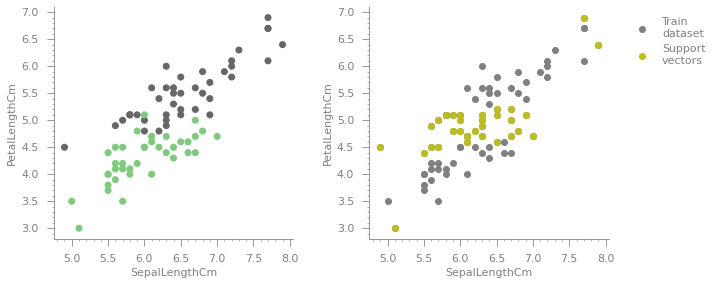

In [89]:
fig, ax = plt.subplots(1,2, figsize = (10,4), constrained_layout = True)
ax[0].scatter(*X_train.T.tolist(), c = y_train, cmap = 'Accent')

ax[1].scatter(*X_train.T.tolist(), c = 'grey', label = 'Train\ndataset')
ax[1].scatter(*svm_sklearn.support_vectors_.T.tolist(), c = 'tab:olive', label = 'Support\nvectors')
ax[1].legend(bbox_to_anchor = (1.05, 1))
for a in ax:
    a.set_xlabel('SepalLengthCm', color = 'grey')
    a.set_ylabel('PetalLengthCm', color = 'grey')

It is quite clear looking at the disposition of the support vectors in the model generated by scikit-learn that this algorithm works differently (quite expected) compared to the one we generated above. In particular, the orientation of the hyperplane separating the 2 classes has a slightly lower slope (even though, the actual dataset in this case was a train subset of the total one). I believe this is likely due to a more sofisticated error function in the version implemented in Scikit-Learn. This algorithm possibly weights more the width of the 'road' encompassing the support vectors than it does in the version implemented here.